In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.datasets import make_regression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Define the pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor())
])

#1. Data Collection and Pre-processing
# Load data (replace with your actual file names)
df = pd.read_csv('1. BASAL.csv')

# Creating a DataFrame from the numpy array #splitting the dataset
X = df.drop(columns=['SPAD'])  # Drop 'sample_id' and 'SPAD' to get the features
y = df['SPAD']  # Target variable

print(df)
print (X)
print(y )

# Check for missing values
print(df.isnull().sum())


      500.075    500.336    500.597    500.858    501.119    501.381  \
0    6.583333   7.472222   8.051111   7.846667   6.714444   6.973333   
1    6.281111   7.166667   7.824444   7.668889   6.552222   6.818889   
2    6.243333   7.154444   7.852222   7.733333   6.630000   6.917778   
3    7.586667   8.887778  10.127778  10.311111   9.137778   9.368889   
4    8.761111  10.051111  11.282222  11.428889  10.226667  10.410000   
..        ...        ...        ...        ...        ...        ...   
94   8.932222  10.238889  11.487778  11.673333  10.480000  10.673333   
95   7.494444   7.561111   7.492222   7.243333   6.858889   7.011111   
96   7.374444   7.472222   7.373333   7.021111   6.511111   6.628889   
97   6.687778   6.856667   6.797778   6.454444   5.890000   6.093333   
98  12.201111  13.646667  15.008889  15.252222  14.128889  14.355556   

      501.642    501.903    502.164    502.425  ...    948.856    949.094  \
0    7.746667   7.578889   6.730000   6.704444  ...  77.78

In [2]:
#Explore data statistics
df.describe()

,500.075,500.336,500.597,500.858,501.119,501.381,501.642,501.903,502.164,502.425,...,948.856,949.094,949.333,949.571,949.809,950.048,950.286,950.524,950.763,SPAD
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,...,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,6.358047,6.660348,6.906229,6.923614,6.589181,6.642817,6.932233,6.923793,6.655735,6.692088,...,46.793199,46.276801,46.420292,46.856846,46.594759,46.225432,46.272166,46.317149,45.945713,31.241313
std,2.450184,2.587438,2.737231,2.717674,2.587619,2.671072,2.801769,2.776750,2.635493,2.576869,...,21.649549,21.733446,21.727518,21.625214,21.764859,21.886222,21.869000,21.934898,22.072896,6.278641
min,2.690000,2.723333,2.723333,2.870000,2.720000,2.673333,2.893333,2.886667,2.660000,2.750000,...,20.640000,19.163333,19.550000,21.106667,20.760000,19.083333,19.643333,20.470000,18.496667,17.200000
25%,3.975000,4.091667,4.348333,4.486667,4.210000,4.120000,4.400000,4.410000,4.200000,4.238333,...,27.691667,27.560000,27.478333,27.521667,27.203333,27.225000,27.180000,26.671667,26.451667,26.650000
50%,6.325556,6.938889,7.076667,6.997778,6.502222,6.736667,6.927778,6.911111,6.540000,6.538889,...,44.620000,43.736667,43.910000,44.426667,44.073333,43.856667,44.016667,44.190000,44.123333,30.800000
75%,8.207222,8.446667,8.456667,8.441667,8.450000,8.520000,8.616667,8.648333,8.606667,8.645000,...,54.924444,54.632222,54.692778,54.938333,54.817222,54.648333,54.706111,54.753889,54.623333,37.500000
max,12.201111,13.646667,15.008889,15.252222,14.128889,14.355556,15.363333,15.263333,14.090000,13.826667,...,106.491111,106.148889,106.332222,106.667778,106.666667,106.353333,106.357778,106.508889,106.068889,42.200000


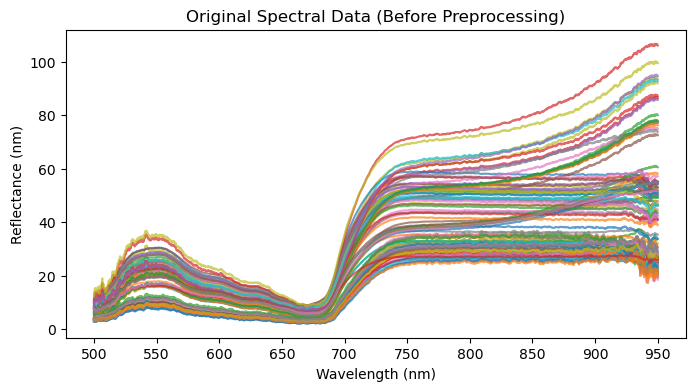

In [3]:
# Create the wavelength range from 500nm to 950nm
wavelengths = np.arange(500, 951, 50)  # Wavelengths from 500nm to 950nm with 100nm intervals
num_wavelengths = X.shape[1]  # Assuming the number of columns in X corresponds to the number of wavelengths

# Plot the spectral data
plt.figure(figsize=(8, 4))
plt.plot(X.T, alpha=0.7)

# Set x-axis labels to the wavelength values (500nm, 600nm, ..., 950nm)
plt.xticks(ticks=np.linspace(0, num_wavelengths-1, len(wavelengths)), labels=wavelengths)

# Add titles and labels
plt.title('Original Spectral Data (Before Preprocessing)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance (nm)')

# Display the plot
plt.show()


In [4]:
# Step 1: Calculate Q1, Q3, and IQR for the spectral data
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# Step 2: Identify outliers in the spectral data
outliers = (X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))

# Step 3: Create a mask to identify rows with any outliers
outlier_mask = outliers.any(axis=1)

# Step 4: Calculate the absolute deviation from the IQR boundaries for ranking
deviation = np.maximum((Q1 - X).abs(), (X - Q3).abs())

# Apply the mask to get deviations only for the identified outliers
deviation = deviation[outlier_mask]

# Step 5: Sum deviations across features for each sample (to rank overall extremeness)
total_deviation = deviation.sum(axis=1)

# Step 6: Calculate the maximum number of outliers to remove (5% of the total data)
num_samples = len(X)
max_outliers_to_remove = int(0.05 * num_samples)

# Get indices of the top 5% most extreme outliers
top_outlier_indices = total_deviation.nlargest(max_outliers_to_remove).index

# Create a new outlier mask based on the top 5% of deviations
final_outlier_mask = pd.Series(False, index=X.index)
final_outlier_mask.loc[top_outlier_indices] = True

# Step 7: Remove the top 5% most extreme outliers
cleaned_spectral_data = X[~final_outlier_mask]
cleaned_spad_data = y[~final_outlier_mask]

# Step 8: Combine the cleaned spectral data and SPAD values back into a single DataFrame (if needed)
cleaned_df = pd.concat([cleaned_spectral_data, cleaned_spad_data], axis=1)

# Step 9: Display the results
print(f"Original dataset size: {X.shape[0]}")
print(f"Number of outliers removed: {final_outlier_mask.sum()}")
print(f"Cleaned dataset size: {cleaned_df.shape[0]}")
print(f"Cleaned spectral data size: {cleaned_spectral_data.shape[0]}")

Original dataset size: 99
Number of outliers removed: 4
Cleaned dataset size: 95
Cleaned spectral data size: 95


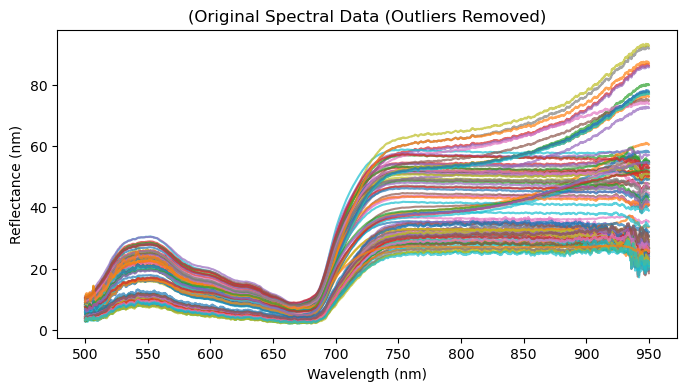

In [5]:
# Create the wavelength range from 500nm to 950nm
wavelengths = np.arange(500, 951, 50)  # Wavelengths from 500nm to 950nm with 100nm intervals
num_columns = cleaned_spectral_data.shape[1]


# Plot the spectral data
plt.figure(figsize=(8, 4))
plt.plot(cleaned_spectral_data.T, alpha=0.7)

# Set x-axis labels to the wavelength values (500nm, 600nm, ..., 950nm)
plt.xticks(ticks=np.linspace(0, num_wavelengths-1, len(wavelengths)), labels=wavelengths)

# Add titles and labels
plt.title('(Original Spectral Data (Outliers Removed)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance (nm)')

# Display the plot
plt.show()

In [6]:
# Step 2: Calculate the correlation matrix for the combined DataFrame
correlation_matrix = cleaned_df.corr()

# Step 3: Extract correlations with the SPAD column (assuming the SPAD column is named 'SPAD')
correlations_with_spad = correlation_matrix['SPAD'].drop('SPAD')

# Step 4: Display the correlation values
print("Correlation values with SPAD:")
print(correlations_with_spad)

# Step 5: Sort correlations by absolute value to find strongest relationships
sorted_correlations = correlations_with_spad.abs().sort_values(ascending=False)
print("Top features correlated with SPAD:")
print(sorted_correlations.head(10))

# Step 6: Set a correlation threshold for feature selection
threshold = 0.5
mask = correlations_with_spad.abs() > threshold

# Step 7: Select features with a correlation higher than the threshold
selected_features = correlations_with_spad[mask].index
X_selected = cleaned_spectral_data[selected_features]


Correlation values with SPAD:
500.075   -0.814672
500.336   -0.777489
500.597   -0.722087
500.858   -0.699534
501.119   -0.739691
             ...   
949.809   -0.431776
950.048   -0.436707
950.286   -0.436658
950.524   -0.437425
950.763   -0.447558
Name: SPAD, Length: 1782, dtype: float64
Top features correlated with SPAD:
695.197    0.869574
695.451    0.869557
694.943    0.869090
695.706    0.868847
696.214    0.868222
694.688    0.868200
693.925    0.868135
696.468    0.868035
694.434    0.867964
693.671    0.867674
Name: SPAD, dtype: float64


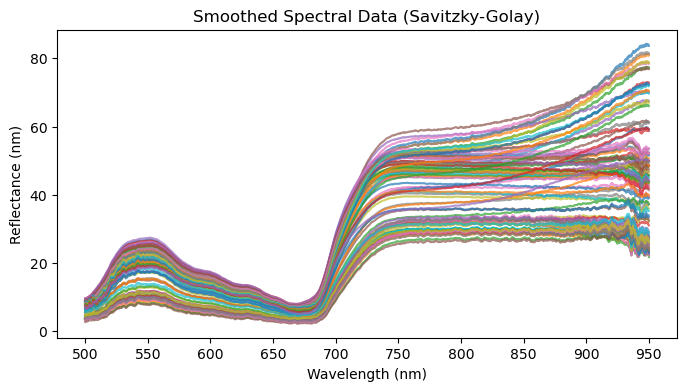

In [7]:
# Function to apply Savitzky-Golay smoothing
def savitzky_golay(cleaned_spectral_data, window_size=11, poly_order=2):
    return savgol_filter(cleaned_spectral_data, window_size, poly_order, axis=0)

# Apply Savitzky-Golay smoothing to X_selected
spectral_sgm = savitzky_golay(cleaned_spectral_data, window_size=11, poly_order=2)

# Create the wavelength range from 500nm to 950nm
wavelengths = np.arange(500, 951, 50)  # Wavelengths from 500nm to 950nm with 100nm intervals
num_columns = spectral_sgm.shape[1]


# Plot the spectral data
plt.figure(figsize=(8, 4))
plt.plot(spectral_sgm.T, alpha=0.7)

# Set x-axis labels to the wavelength values (500nm, 600nm, ..., 950nm)
plt.xticks(ticks=np.linspace(0, num_wavelengths-1, len(wavelengths)), labels=wavelengths)

# Add titles and labels
plt.title('Smoothed Spectral Data (Savitzky-Golay)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance (nm)')

# Display the plot
plt.show()

In [8]:
# Apply PCA to determine the number of components to retain 95% variance
#pca = PCA()
#X_train_pca = pca.fit_transform(spectral_sgm)
#X_test_pca = pca.transform(spectral_sgm)
#explained_variance_ratio = pca.explained_variance_ratio_
#cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Scree plot
#plt.figure(figsize=(8, 4))
#plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', label='Individual explained variance')
#plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', label='Cumulative explained variance')
#plt.xlabel('Number of Principal Components')
#plt.ylabel('Explained Variance Ratio')
#plt.legend()
#plt.title('Scree Plot')
#plt.grid(True)
#plt.show()

# Choose number of components to retain 95% variance
#n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
#print(f"Number of components to retain 95% variance: {n_components}")

In [9]:
import numpy as np

def calculate_indices(spectral_data, wavelengths):
    """
    Calculate various vegetation indices based on spectral data.

    Parameters:
    spectral_data: numpy array (samples x wavelengths)
    wavelengths: numpy array of corresponding wavelengths (same length as spectral_data columns)

    Returns:
    indices: Dictionary of calculated indices
    """
    # Define the wavelength ranges for each band
    blue_band = np.mean(spectral_data[:, (wavelengths >= 450) & (wavelengths <= 500)], axis=1)
    green_band = np.mean(spectral_data[:, (wavelengths >= 500) & (wavelengths <= 600)], axis=1)
    red_band = np.mean(spectral_data[:, (wavelengths >= 600) & (wavelengths <= 700)], axis=1)
    nir_band = np.mean(spectral_data[:, (wavelengths >= 750) & (wavelengths <= 950)], axis=1)
    red_edge_band = np.mean(spectral_data[:, (wavelengths >= 700) & (wavelengths <= 750)], axis=1)

    # Calculate indices
    ndvi = (nir_band - red_band) / (nir_band + red_band)
    savi = (1.5 * (nir_band - red_band)) / (nir_band + red_band + 0.5)
    msavi = (2 * nir_band + 1 - np.sqrt((2 * nir_band + 1)**2 - 8 * (nir_band - red_band))) / 2
    gndvi = (nir_band - green_band) / (nir_band + green_band)
    rvi = nir_band / red_band
    tvi = 0.5 * (120 * (nir_band - green_band) - 200 * (red_band - green_band))
    rdvi = (nir_band - red_band) / np.sqrt(nir_band + red_band)
    cigreen = (nir_band / green_band) - 1

    # Store the results in a dictionary
    indices = {
        "NDVI": ndvi,
        "SAVI": savi,
        "MSAVI": msavi,
        "GNDVI": gndvi,
        "RVI": rvi,
        "TVI": tvi,
        "RDVI": rdvi,
        "CIgreen": cigreen
    }
    
    return indices

# Example usage:
# Define wavelengths to match the number of columns in spectral_data
num_samples = 100
num_wavelengths = 200
wavelengths = np.linspace(500, 950, num_wavelengths)
spectral_data = np.random.rand(num_samples, num_wavelengths)  # Example spectral data

# Calculate indices
indices = calculate_indices(spectral_data, wavelengths)

# Output indices for each sample
for index_name, index_values in indices.items():
    print(f"{index_name}: {index_values[:5]}")  # Display first 5 samples of each index



NDVI: [-0.09171752 -0.02262202 -0.00652773  0.0102228   0.02256857]
SAVI: [-0.0918136  -0.02213171 -0.00672708  0.01041416  0.02301032]
MSAVI: [-0.09186806 -0.02188682 -0.00683247  0.01051098  0.02322965]
GNDVI: [-0.07455051  0.05181025  0.09904935 -0.00812347 -0.00590198]
RVI: [0.83197572 0.95575683 0.98702922 1.02065677 1.04617934]
TVI: [-6.26471552 -3.92695978 -4.64730818  1.43217816  2.65246357]
RDVI: [-0.09186183 -0.02190577 -0.00683879  0.01051678  0.02324797]
CIgreen: [-0.13875664  0.10928245  0.21987742 -0.01611603 -0.01173469]


In [10]:
#from sklearn.decomposition import FastICA
from sklearn.decomposition import FastICA
#Assume spectral_sgm is your input data after preprocessing
ica = FastICA(n_components=5, max_iter=500, tol=0.01, random_state=175)

# Apply ICA to the spectral data
X_ica = ica.fit_transform(spectral_sgm)

# Check the shape of the transformed data
print(f"Shape of ICA-transformed data: {X_ica.shape}")


Shape of ICA-transformed data: (95, 5)


In [11]:
# 4. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_ica,cleaned_spad_data, test_size=0.20, random_state=175)

In [12]:

# Custom CFS-like feature selection function
def cfs_feature_selection(X_train, y_train, target_corr_threshold=0.1, feature_corr_threshold=0.9):
    # Calculate correlation matrix
    correlation_matrix = pd.DataFrame(X_train).corr()

    # Calculate correlations with the target (y)
    target_correlations = np.array([np.corrcoef(X_train[:, i], y_train)[0, 1] for i in range(X_train.shape[1])])

    # Step 1: Select features based on their correlation with the target
    selected_features = np.where(np.abs(target_correlations) >= target_corr_threshold)[0]

    # Step 2: Remove highly correlated features among themselves
    # Check correlations among the selected features
    filtered_features = []
    
    for feature_idx in selected_features:
        add_feature = True
        for filtered_idx in filtered_features:
            if np.abs(correlation_matrix.iloc[feature_idx, filtered_idx]) >= feature_corr_threshold:
                add_feature = False
                break
        if add_feature:
            filtered_features.append(feature_idx)
    
    # Return filtered features and their indices
    return X_train[:, filtered_features], filtered_features

# Apply CFS-like feature selection
X_train_cfs, selected_features = cfs_feature_selection(X_train, y_train, target_corr_threshold=0.1, feature_corr_threshold=0.9)

# Transform X_test using selected features from X_train
X_test_cfs = X_test[:, selected_features]

# Display the selected features
print(f"Number of features selected by CFS: {len(selected_features)}")
print("Selected feature indices (CFS):", selected_features)

Number of features selected by CFS: 3
Selected feature indices (CFS): [1, 2, 3]


In [47]:
# Define parameter grids for RandomizedSearchCV
# Parameter grid for RandomizedSearchCV
n_estimators = np.arange(5, 95, 5)
max_depth = np.arange(5, 50, 3)
min_samples_split = np.arange(4, 50, 5)
min_samples_leaf = np.arange(4, 50,5)
min_impurity_decrease = np.linspace(0, 0.1, 2)
# Adding max_features and min_impurity_decrease to help control complexity
param_dist_rf = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'min_impurity_decrease': min_impurity_decrease,  # Helps reduce overfitting
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2']
   
}
# Initialize models
model_rf = RandomForestRegressor(random_state=175)

# Perform RandomizedSearchCV for each model
random_search_rf = RandomizedSearchCV(model_rf, param_distributions=param_dist_rf, n_iter=175, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_rf.fit(X_train_cfs, y_train)
best_rf = random_search_rf.best_estimator_
best_params_rf = random_search_rf.best_params_
print("Best parameters for Random Forest: ", best_params_rf)
# Cross-validation with the best hyperparameters for each model
mse_scores_rf = cross_val_score(best_rf, X_train_cfs, y_train, scoring='neg_mean_squared_error', cv=5)
# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_rf = -mse_scores_rf
average_mse_rf = np.mean(mse_scores_rf)

# Print cross-validation results
print(f"Average MSE for Random Forest: {average_mse_rf}")

# Evaluate the individual models
models = {
    "RandomForest": best_rf
}

# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_cfs, y_train)
    
    y_train_pred = model.predict(X_train_cfs)
    y_test_pred = model.predict(X_test_cfs)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)


Best parameters for Random Forest:  {'n_estimators': 55, 'min_samples_split': 9, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.1, 'max_features': 'auto', 'max_depth': 41, 'bootstrap': True}
Average MSE for Random Forest: 10.076327817405073
Evaluating RandomForest model...
Training Metrics:
                   MAE       MSE   Pearson        R2      RMSE       RPD
RandomForest  1.375697  3.743679  0.951396  0.904687  1.934859  3.239105

Testing Metrics:
                  MAE       MSE   Pearson        R2      RMSE       RPD
RandomForest  2.14641  8.609053  0.915383  0.810108  2.934119  2.294811


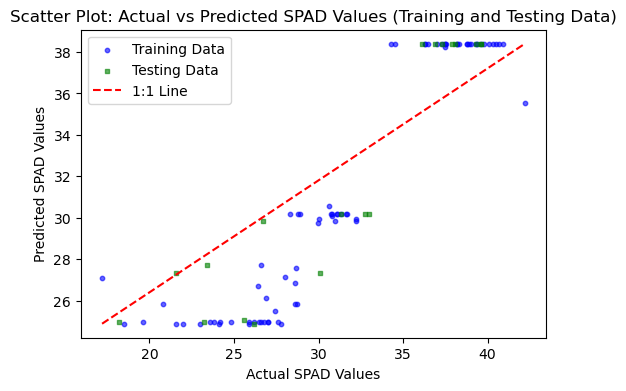

In [14]:
import matplotlib.pyplot as plt

# Assuming these are your actual and predicted SPAD values for both training and testing sets
y_train_actual = y_train # Replace with your actual training SPAD values
y_train_predicted = y_train_pred # Replace with your predicted SPAD values from the model (training)

y_test_actual = y_test  # Replace with your actual testing SPAD values
y_test_predicted = y_test_pred  # Replace with your predicted SPAD values from the model (testing)

# Combined Plot
plt.figure(figsize=(6, 4))

# Scatter plot for Training Data (circles)
plt.scatter(y_train_actual, y_train_predicted, color='blue', alpha=0.6, s=10, marker='o', label='Training Data')

# Scatter plot for Testing Data (squares)
plt.scatter(y_test_actual, y_test_predicted, color='green', alpha=0.6, s=10, marker='s', label='Testing Data')

# Plot the 1:1 line (perfect prediction)
plt.plot([min(min(y_train_actual), min(y_test_actual)), max(max(y_train_actual), max(y_test_actual))],
         [min(min(y_train_predicted), min(y_test_predicted)), max(max(y_train_predicted), max(y_test_predicted))],
         color='red', linestyle='--', label='1:1 Line')

# Labels and title
plt.xlabel('Actual SPAD Values', fontsize=10)
plt.ylabel('Predicted SPAD Values', fontsize=10)
plt.title('Scatter Plot: Actual vs Predicted SPAD Values (Training and Testing Data)', fontsize=12)

# Add legend
plt.legend()

# Remove grid and display plot
plt.show()



In [86]:
# Define parameter grids for RandomizedSearchCV
n_estimators = np.arange(5, 150,4)
learning_rate = np.arange(0.1, 1, 0.2)
max_depth = np.arange(2, 50, 1)
subsample = np.arange(0.9, 1.0, 0.5) 
colsample_bytree = np.arange(0.5, 1.0, 0.5)

# Additional hyperparameters to help control model complexity
gamma = np.arange(0, 0.5, 0.05)  # Regularization term to reduce overfitting
reg_lambda = np.arange(0.6, 1.0, 0.6)  # L2 regularization
reg_alpha = np.arange(0.5, 1.0, 0.6)  # L1 regularization

param_dist_xgb = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'max_depth': max_depth,
    'subsample': subsample,
    'colsample_bytree': colsample_bytree,
    'gamma': gamma,  # Regularization parameters
    'reg_lambda': reg_lambda,
    'reg_alpha': reg_alpha
}
# Initialize models
model_xgb = XGBRegressor(objective='reg:squarederror', random_state=175)
# Perform RandomizedSearchCV for each model
random_search_xgb = RandomizedSearchCV(model_xgb, param_distributions=param_dist_xgb, n_iter=175, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_xgb.fit(X_train_cfs, y_train)
best_xgb = random_search_xgb.best_estimator_
best_params_xgb = random_search_xgb.best_params_
print("Best parameters for XGBoost: ", best_params_xgb)
# Cross-validation with the best hyperparameters for each model
mse_scores_xgb = cross_val_score(best_xgb, X_train_cfs, y_train, scoring='neg_mean_squared_error', cv=5)
# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_xgb = -mse_scores_xgb
average_mse_xgb = np.mean(mse_scores_xgb)
# Print cross-validation results
print(f"Average MSE for XGBoost: {average_mse_xgb}")


# Evaluate the individual models
models = {
      "XGBoost": best_xgb
}

# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_cfs, y_train)
    
    y_train_pred = model.predict(X_train_cfs)
    y_test_pred = model.predict(X_test_cfs)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)


Best parameters for XGBoost:  {'subsample': 0.9, 'reg_lambda': 0.6, 'reg_alpha': 0.5, 'n_estimators': 121, 'max_depth': 2, 'learning_rate': 0.30000000000000004, 'gamma': 0.1, 'colsample_bytree': 0.5}
Average MSE for XGBoost: 13.157574899739615
Evaluating XGBoost model...
Training Metrics:
              MAE       MSE   Pearson        R2      RMSE        RPD
XGBoost  0.458855  0.310013  0.996277  0.992107  0.556788  11.256005

Testing Metrics:
              MAE       MSE   Pearson        R2     RMSE       RPD
XGBoost  2.152124  8.593049  0.920044  0.810461  2.93139  2.296947


In [93]:
# Define parameter grids for RandomizedSearchCV
n_estimators = np.arange(2,200,2)
learning_rate = np.arange(0.01, 1, 0.09)
max_depth = np.arange(2, 40,3)

param_dist_gb = {
   'n_estimators': n_estimators,
   'learning_rate': learning_rate,
   'max_depth': max_depth
}

# Initialize models
model_gb = GradientBoostingRegressor(random_state=175)

# Perform RandomizedSearchCV for each model
random_search_gb = RandomizedSearchCV(model_gb, param_distributions=param_dist_gb, n_iter=48, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_gb.fit(X_train_cfs, y_train)
best_gb = random_search_gb.best_estimator_
best_params_gb = random_search_gb.best_params_
print("Best parameters for Gradient Boosting: ", best_params_gb)
# Cross-validation with the best hyperparameters for each model
mse_scores_gb = cross_val_score(best_gb, X_train_cfs, y_train, scoring='neg_mean_squared_error', cv=5)

# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_gb = -mse_scores_gb
average_mse_gb = np.mean(mse_scores_gb)
# Print cross-validation results
print(f"Average MSE for Gradient Boosting: {average_mse_gb}")
# Evaluate the individual models
models = {
    "GradientBoosting": best_gb
    }
# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_cfs, y_train)
    
    y_train_pred = model.predict(X_train_cfs)
    y_test_pred = model.predict(X_test_cfs)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)


Best parameters for Gradient Boosting:  {'n_estimators': 16, 'max_depth': 2, 'learning_rate': 0.09999999999999999}
Average MSE for Gradient Boosting: 12.279527852085119
Evaluating GradientBoosting model...
Training Metrics:
                       MAE       MSE  Pearson        R2      RMSE       RPD
GradientBoosting  1.765702  6.075095  0.93843  0.845331  2.464771  2.542716

Testing Metrics:
                       MAE        MSE   Pearson        R2      RMSE       RPD
GradientBoosting  2.661864  12.853023  0.877477  0.716498  3.585111  1.878114


In [105]:
# Define parameter grids for RandomizedSearchCV
C = np.arange(0.1, 3, 0.1)
epsilon = np.arange(1, 30, 2)

param_dist_svr = {
    'C': C,
    'epsilon': epsilon,
    'kernel': ['linear', 'rbf']
}
# Initialize models
model_svr = SVR()
# Perform RandomizedSearchCV for each model
random_search_svr = RandomizedSearchCV(model_svr, param_distributions=param_dist_svr, n_iter=150, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_svr.fit(X_train_cfs, y_train)
best_svr = random_search_svr.best_estimator_
best_params_svr = random_search_svr.best_params_
print("Best parameters for SVR: ", best_params_svr)
# Cross-validation with the best hyperparameters for each model
mse_scores_svr = cross_val_score(best_svr, X_train_cfs, y_train, scoring='neg_mean_squared_error', cv=5)

# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_svr = -mse_scores_svr
average_mse_svr = np.mean(mse_scores_svr)
# Print cross-validation results
print(f"Average MSE for SVR: {average_mse_svr}")
# Evaluate the individual models
models = {
    "SVR": best_svr
}
# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_cfs, y_train)
    
    y_train_pred = model.predict(X_train_cfs)
    y_test_pred = model.predict(X_test_cfs)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)

Best parameters for SVR:  {'kernel': 'rbf', 'epsilon': 1, 'C': 1.9000000000000001}
Average MSE for SVR: 9.37784145492165
Evaluating SVR model...
Training Metrics:
          MAE       MSE   Pearson        R2     RMSE       RPD
SVR  1.899539  7.222333  0.912378  0.816122  2.68744  2.332038

Testing Metrics:
          MAE        MSE  Pearson        R2     RMSE       RPD
SVR  2.535464  13.505477  0.88132  0.702107  3.67498  1.832186


In [122]:
# Define parameter grids for RandomizedSearchCV
alpha = np.logspace(-6, 50, 1)  # Range from 0.001 to 100
l1_ratio = np.linspace(0.1, 1, 100)  # More granular search for l1 ratio

param_dist_elnet = {
    'alpha': alpha,
    'l1_ratio': l1_ratio
}
# Initialize models
model_elnet = ElasticNet(random_state=175) 
# Perform RandomizedSearchCV for each model
random_search_elnet = RandomizedSearchCV(model_elnet, param_distributions=param_dist_elnet, n_iter=25, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_elnet.fit(X_train_cfs, y_train)
best_elnet = random_search_elnet.best_estimator_
best_params_elnet = random_search_elnet.best_params_
print("Best parameters for Elastic Net: ", best_params_elnet)
# Cross-validation with the best hyperparameters for each model
mse_scores_elnet = cross_val_score(best_elnet, X_train_cfs, y_train, scoring='neg_mean_squared_error', cv=5)

# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_elnet = -mse_scores_elnet
average_mse_elnet = np.mean(mse_scores_elnet)
# Print cross-validation results
print(f"Average MSE for Elastic Net: {average_mse_elnet}")
# Evaluate the individual models
models = {
    "ElasticNet": best_elnet
}
# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_cfs, y_train)
    
    y_train_pred = model.predict(X_train_cfs)
    y_test_pred = model.predict(X_test_cfs)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)

Best parameters for Elastic Net:  {'l1_ratio': 0.1, 'alpha': 1e-06}
Average MSE for Elastic Net: 9.474753937814139
Evaluating ElasticNet model...
Training Metrics:
                 MAE       MSE   Pearson        R2      RMSE       RPD
ElasticNet  2.249745  8.860227  0.880013  0.774422  2.976613  2.105484

Testing Metrics:
                 MAE        MSE   Pearson        R2      RMSE       RPD
ElasticNet  3.408384  17.031695  0.807906  0.624328  4.126947  1.631532


In [125]:
# Define parameter grids for RandomizedSearchCV

# Initialize models
model_plsr = PLSRegression(n_components=1) 

# Perform RandomizedSearchCV for each model
# PLSR does not require hyperparameter tuning here
best_plsr = model_plsr
best_plsr.fit(X_train_cfs, y_train)
# Cross-validation with the best hyperparameters for each model

mse_scores_plsr = cross_val_score(best_plsr, X_train_cfs, y_train, scoring='neg_mean_squared_error', cv=5)
# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_plsr = -mse_scores_plsr
average_mse_plsr = np.mean(mse_scores_plsr)
# Print cross-validation results
print(f"Average MSE for PLSR: {average_mse_plsr}")
# Evaluate the individual models
models = {
    "PLSR": best_plsr
}
# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_cfs, y_train)
    
    y_train_pred = model.predict(X_train_cfs)
    y_test_pred = model.predict(X_test_cfs)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)

Average MSE for PLSR: 9.73337926939919
Evaluating PLSR model...
Training Metrics:
           MAE       MSE   Pearson        R2      RMSE       RPD
PLSR  2.272657  8.907996  0.879321  0.773206  2.984627  2.099831

Testing Metrics:
           MAE        MSE   Pearson        R2      RMSE       RPD
PLSR  3.326202  16.461637  0.817499  0.636902  4.057294  1.659541


In [20]:
# Ensemble the models using Voting Regressor
ensemble_model = VotingRegressor(estimators=[
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('gb', best_gb),
    ('svr', best_svr),
    ('elnet', best_elnet)
])

ensemble_model.fit(X_train_cfs, y_train)
y_ensemble_pred = ensemble_model.predict(X_test_cfs)

# Evaluate the ensemble model
ensemble_metrics_train = calculate_metrics(y_train, ensemble_model.predict(X_train_cfs))
ensemble_metrics_test = calculate_metrics(y_test, y_ensemble_pred)
print("\nEnsemble Model Training Metrics:")
print(pd.DataFrame(ensemble_metrics_train, index=["Ensemble"]).T)
print("\nEnsemble Model Testing Metrics:")
print(pd.DataFrame(ensemble_metrics_test, index=["Ensemble"]).T)


Ensemble Model Training Metrics:
         Ensemble
MSE      4.639329
RMSE     2.153910
MAE      1.582312
R2       0.881885
RPD      2.909691
Pearson  0.944480

Ensemble Model Testing Metrics:
          Ensemble
MSE      11.948008
RMSE      3.456589
MAE       2.598712
R2        0.736460
RPD       1.947946
Pearson   0.881745


In [21]:
# Ensemble the models using Voting Regressor # 2 the best model ensembled
ensemble_model = VotingRegressor(estimators=[
    ('rf', best_rf),
    ('xgb', best_xgb)
])

ensemble_model.fit(X_train_cfs, y_train)
y_ensemble_pred = ensemble_model.predict(X_test_cfs)

# Evaluate the ensemble model
ensemble_metrics_train = calculate_metrics(y_train, ensemble_model.predict(X_train_cfs))
ensemble_metrics_test = calculate_metrics(y_test, y_ensemble_pred)
print("\nEnsemble Model Training Metrics:")
print(pd.DataFrame(ensemble_metrics_train, index=["Ensemble"]).T)
print("\nEnsemble Model Testing Metrics:")
print(pd.DataFrame(ensemble_metrics_test, index=["Ensemble"]).T)


Ensemble Model Training Metrics:
         Ensemble
MSE      3.603626
RMSE     1.898322
MAE      1.400704
R2       0.908253
RPD      3.301449
Pearson  0.954819

Ensemble Model Testing Metrics:
         Ensemble
MSE      9.581478
RMSE     3.095396
MAE      2.319386
R2       0.788659
RPD      2.175246
Pearson  0.908193
